# 🤖 Deep Dive: What Drives AI Video Virality?

This advanced EDA notebook explores the relationships between video features and virality success. We analyze 4 different definitions of success using statistical tests and comprehensive visualizations.

## 🎯 Analysis Dimensions
1. **Temporal Patterns**: Best upload times and seasonality.
2. **Content Optimization**: Impact of duration, quality, and captions.
3. **Title & Psychology**: Effect of emojis, questions, caps lock, and length.
4. **Channel Authority**: How subscriber count correlates with video performance.
5. **Statistical Validation**: Chi-square and ANOVA tests to confirm findings.

In [21]:
# Imports & Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Load Data
try:
    df = pd.read_csv('dataset/processed/youtube_virality_dataset.csv')
    print(f"Dataset Loaded Successfully: {df.shape}")
except FileNotFoundError:
    print("Error: Dataset not found. Please run the data pipeline first.")

# Virality Classes Order
ORDER = ['Non-viral', 'Moderate', 'High', 'Viral']

Dataset Loaded Successfully: (3812, 36)


## 1. 🏆 Target Analysis
We have 4 different ways to define "success". Let's see how they interact.

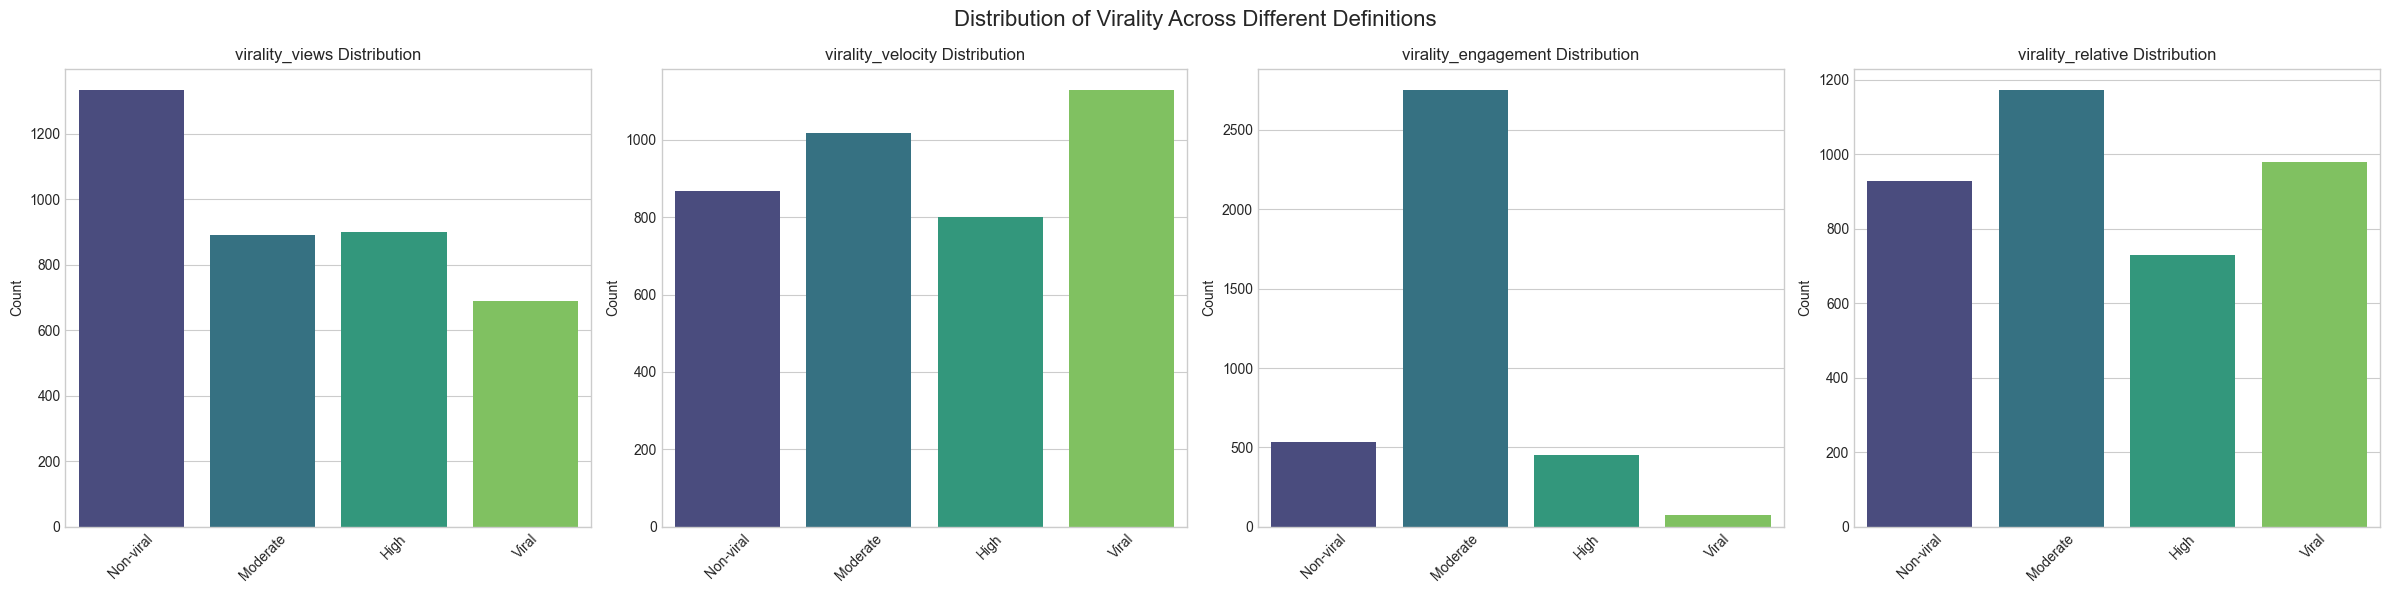

In [22]:
metrics = ['virality_views', 'virality_velocity', 'virality_engagement', 'virality_relative']

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
for i, metric in enumerate(metrics):
    sns.countplot(data=df, x=metric, order=ORDER, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{metric} Distribution')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Distribution of Virality Across Different Definitions', fontsize=16)
plt.tight_layout()
plt.show()

## 2. ⏰ Temporal Anatomy of a Hit
**Features**: `upload_day_of_week`, `upload_hour`, `is_weekend`

### Q: Is there a "Golden Hour" for AI content?

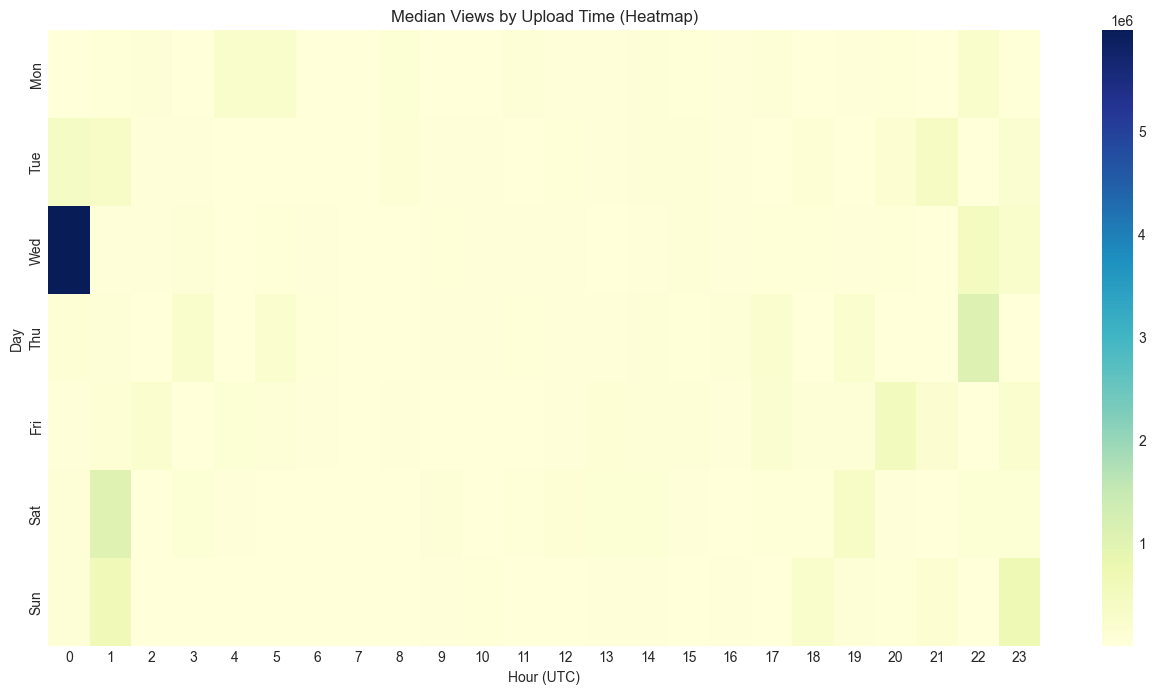

Weekend vs Weekday T-Test P-value: 0.0002
✅ Significant difference found between Weekend and Weekday performance.


In [23]:
# Heatmap: Day vs Hour
plt.figure(figsize=(16, 8))
pivot = df.pivot_table(
    index='upload_day_of_week', 
    columns='upload_hour', 
    values='view_count', 
    aggfunc='median'
)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot.index = [days[i] for i in pivot.index]

sns.heatmap(pivot, cmap='YlGnBu', annot=False, fmt='.0f')
plt.title('Median Views by Upload Time (Heatmap)')
plt.xlabel('Hour (UTC)')
plt.ylabel('Day')
plt.show()

# Statistical Test: Weekend vs Weekday
weekend_views = df[df['is_weekend'] == 1]['view_count']
weekday_views = df[df['is_weekend'] == 0]['view_count']
t_stat, p_val = stats.ttest_ind(np.log1p(weekend_views), np.log1p(weekday_views))

print(f"Weekend vs Weekday T-Test P-value: {p_val:.4f}")
if p_val < 0.05:
    print("✅ Significant difference found between Weekend and Weekday performance.")
else:
    print("❌ No significant difference based on purely weekend/weekday.")

## 3. 🎬 Video Metadata: Optimization
**Features**: `duration`, `definition`, `captions`

### Q: Do shorter videos perform better? (Attention Spans)

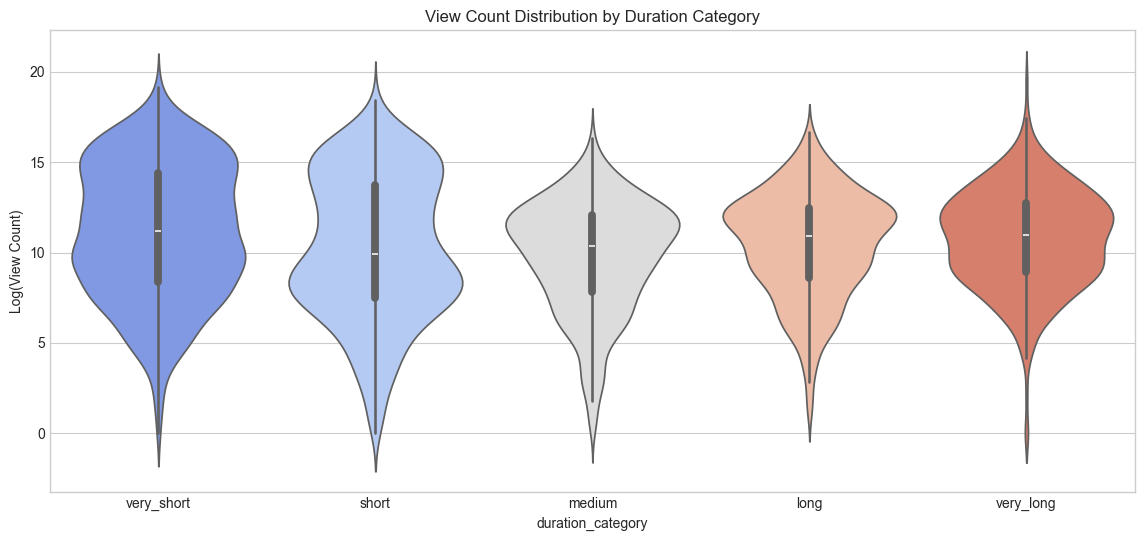

In [24]:
plt.figure(figsize=(14, 6))
duration_order = ['very_short', 'short', 'medium', 'long', 'very_long']
sns.violinplot(data=df, x='duration_category', y=np.log1p(df['view_count']), order=duration_order, palette='coolwarm')
plt.title('View Count Distribution by Duration Category')
plt.ylabel('Log(View Count)')
plt.show()

### Q: Does Quality (HD/SD) and Captions matter?
We use Chi-square tests to see if these binary features affect Virality Labels.

In [25]:
def run_chi2(feature, target='virality_views'):
    contingency = pd.crosstab(df[feature], df[target])
    chi2, p, dof, ex = stats.chi2_contingency(contingency)
    return p

features = ['definition', 'has_captions', 'has_maxres_thumbnail']
results = []

for f in features:
    if f in df.columns:
        p = run_chi2(f)
        sig = "✅ Significant" if p < 0.05 else "❌ Not Significant"
        results.append({'Feature': f, 'P-Value': f"{p:.4f}", 'Result': sig})

pd.DataFrame(results)

,Feature,P-Value,Result
0,definition,0.0002,✅ Significant
1,has_captions,0.0000,✅ Significant
2,has_maxres_thumbnail,0.0000,✅ Significant


## 4. ✍️ Title Psychology
**Features**: `title_length`, `emoji`, `questions`, `caps`

### Q: Do "Clickbait" tactics (All Caps, Emojis, Questions) work?

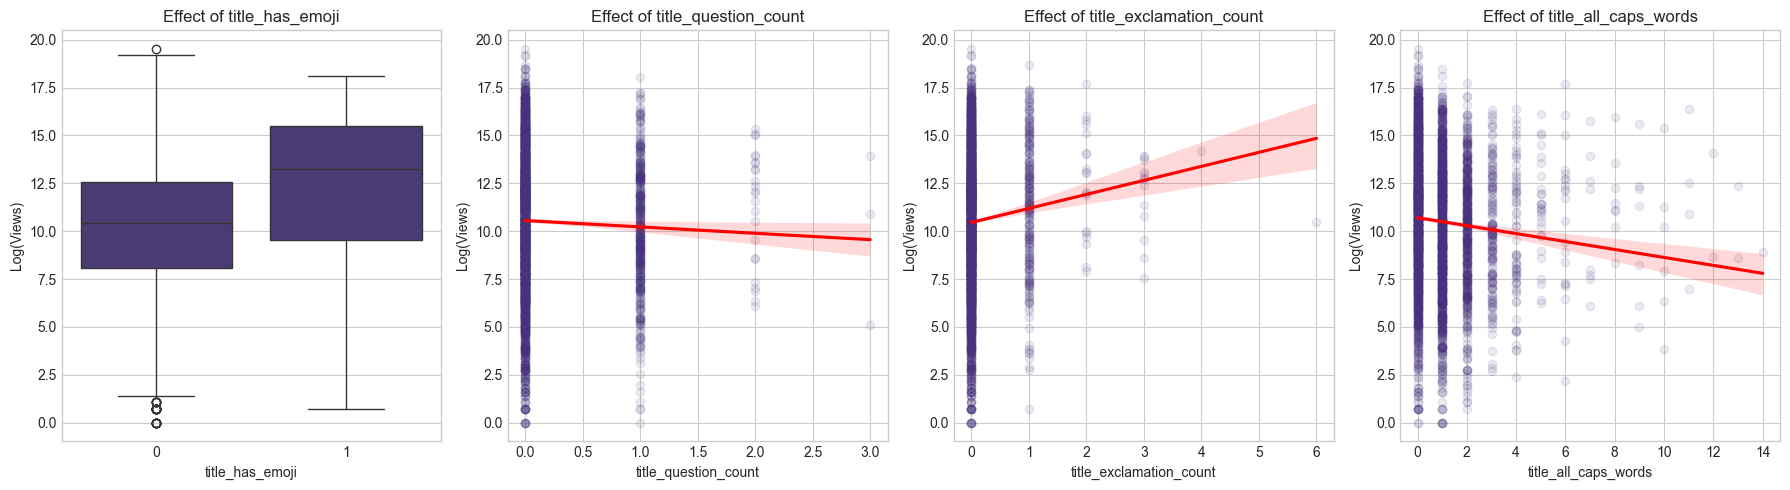

In [26]:
tactics = ['title_has_emoji', 'title_question_count', 'title_exclamation_count', 'title_all_caps_words']

plt.figure(figsize=(18, 5))
for i, tactic in enumerate(tactics, 1):
    if tactic in df.columns:
        plt.subplot(1, 4, i)
        # Convert counts to binary "Has X" for cleaner plot if many zeros
        if df[tactic].max() > 1:
            x_data = df[tactic].apply(lambda x: f'Has {tactic}' if x > 0 else 'No')
            # actually keep it numeric for correlation visualization
            sns.regplot(x=df[tactic], y=np.log1p(df['view_count']), scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
        else:
            sns.boxplot(x=tactic, y=np.log1p(df['view_count']), data=df)
        plt.title(f'Effect of {tactic}')
        plt.ylabel('Log(Views)')

plt.tight_layout()
plt.show()

## 5. 📺 Channel Authority vs Virality
**Features**: `subscriber_count`, `channel_age`

### Q: Can small channels go viral?

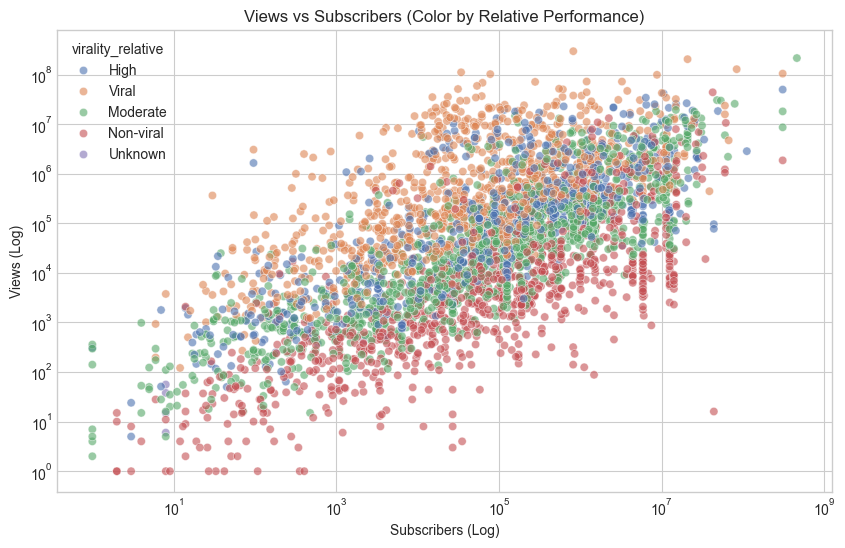

Insight: Points HIGH on the Y-axis but LEFT on the X-axis are 'Breakout' videos from small channels.


In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='channel_subscriber_count', y='view_count', hue='virality_relative', palette='deep', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.title('Views vs Subscribers (Color by Relative Performance)')
plt.xlabel('Subscribers (Log)')
plt.ylabel('Views (Log)')
plt.show()

print("Insight: Points HIGH on the Y-axis but LEFT on the X-axis are 'Breakout' videos from small channels.")

## 6. 📝 Description & SEO
**Features**: `hashtags`, `links`, `length`

Correlation matrix of description features:

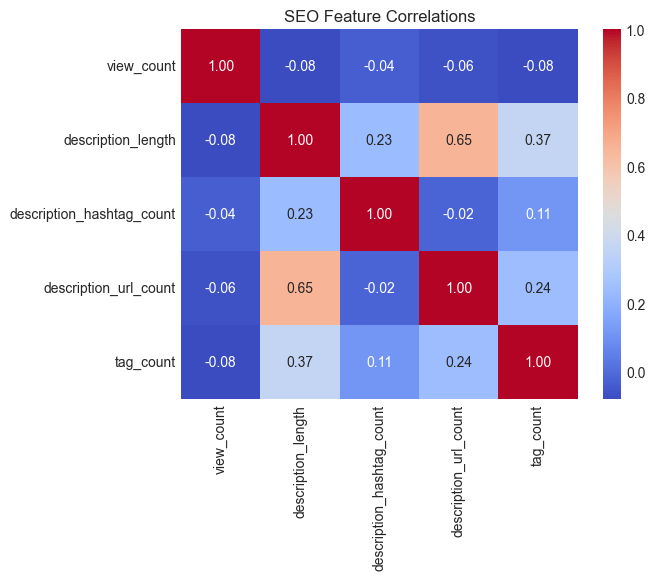

In [28]:
desc_cols = ['view_count', 'description_length', 'description_hashtag_count', 'description_url_count', 'tag_count']
sns.heatmap(df[desc_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('SEO Feature Correlations')
plt.show()

## 7. 🧪 Outlier Detection: Finding the "Hidden Gems"
Let's find videos that are **Viral** despite having **Low Subscribers** (High Relative Performance).

In [29]:
# Filter: < 10k Subs BUT > 100k Views
hidden_gems = df[
    (df['channel_subscriber_count'] < 10000) & 
    (df['view_count'] > 100000)
].sort_values('view_count', ascending=False)

print(f"Found {len(hidden_gems)} Hidden Gems!")
print("Examples:")
hidden_gems[['video_id', 'view_count', 'channel_subscriber_count', 'title_length', 'upload_day_of_week']].head(10)

Found 94 Hidden Gems!
Examples:


,video_id,view_count,channel_subscriber_count,title_length,upload_day_of_week
1489,gqsYY4LKwFI,14530116,9170,47,5
63,7zHkl-QgLpw,8446230,4090,76,3
11,36JdmtvrnzA,8303109,5720,54,3
2193,6eBi2u3k1lU,7011075,3800,59,2
803,HW20azknOxc,6365047,8550,61,3
3436,IuYsaw0qX9Y,5882051,1930,21,4
3467,p7pec1ePLLI,3058629,96,14,0
670,CIQCH1oRD00,2809358,854,78,0
3707,19o3R_AVats,2591955,4950,37,4
1768,8PGLfDmMiAw,2504325,9600,91,5
